In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping

In [2]:
data=yf.download('HSI','2020-01-01','2022-01-01')
data.drop('Volume',1,inplace=True)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_45935/963280979.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Volume',1,inplace=True)


,Open,High,Low,Close,Adj Close,Prediction
Date,,,,,,
2020-01-23,27909.099609,27909.099609,27909.099609,27909.099609,27909.099609,27949.599609
2020-01-24,27949.599609,27949.599609,27949.599609,27949.599609,27949.599609,27160.599609
2020-01-29,27160.599609,27160.599609,27160.599609,27160.599609,27160.599609,26449.099609
2020-01-30,26449.099609,26449.099609,26449.099609,26449.099609,26449.099609,26312.599609
2020-01-31,26312.599609,26312.599609,26312.599609,26312.599609,26312.599609,26357.000000
...,...,...,...,...,...,...
2021-12-23,23193.599609,23193.599609,23193.599609,23193.599609,23193.599609,23223.800781
2021-12-27,23223.800781,23223.800781,23223.800781,23223.800781,23223.800781,23280.599609
2021-12-28,23280.599609,23280.599609,23280.599609,23280.599609,23280.599609,23086.500000


In [3]:
data_val=data[-100:]
data=data[:-100]

In [4]:
# sc = MinMaxScaler(feature_range = (-1, 1))
sc_y= MinMaxScaler(feature_range = (0, 1))

In [5]:
# X=sc.fit_transform(data.drop('Prediction',1))
X=data.drop('Prediction',1).values
# Y = data["Prediction"].values.reshape(-1,1)
# Y = sc_y.fit_transform(data["Prediction"].values.reshape(-1,1))
Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(296, 1, 5) (296,) (74, 1, 5) (74,)


/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_45935/2546918542.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=data.drop('Prediction',1).values


In [6]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True
   
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

Metal device set to: Apple M1 Pro


2022-04-10 18:48:16.890934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-10 18:48:16.891067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.001)
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=700,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
    callbacks=[es]
)
y_pred = model_tech.predict(X_test)

Epoch 1/700


2022-04-10 18:48:17.910515: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-10 18:48:19.162649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:48:19.395269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:48:19.879206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:48:21.126451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:48:21.638557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 656568960.0000

2022-04-10 18:48:23.208958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:48:23.285452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:48:23.309414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 6s 116ms/step - loss: 656568960.0000 - val_loss: 842324160.0000
Epoch 2/700
17/17 [==============================] - 0s 13ms/step - loss: 656317120.0000 - val_loss: 841873216.0000
Epoch 3/700
17/17 [==============================] - 0s 11ms/step - loss: 655739392.0000 - val_loss: 840961088.0000
Epoch 4/700
17/17 [==============================] - 0s 11ms/step - loss: 654714688.0000 - val_loss: 839516480.0000
Epoch 5/700
17/17 [==============================] - 0s 10ms/step - loss: 653244800.0000 - val_loss: 837618752.0000
Epoch 6/700
17/17 [==============================] - 0s 10ms/step - loss: 651429440.0000 - val_loss: 835391040.0000
Epoch 7/700
17/17 [==============================] - 0s 10ms/step - loss: 649356672.0000 - val_loss: 832901440.0000
Epoch 8/700
17/17 [==============================] - 0s 10ms/step - loss: 647064576.0000 - val_loss: 830170432.0000
Epoch 9/700
17/17 [==============================] - 0s 10ms/step - loss: 644562432

17/17 [==============================] - 0s 9ms/step - loss: 238922128.0000 - val_loss: 349682816.0000
Epoch 72/700
17/17 [==============================] - 0s 9ms/step - loss: 231904448.0000 - val_loss: 341118880.0000
Epoch 73/700
17/17 [==============================] - 0s 9ms/step - loss: 224976256.0000 - val_loss: 332642560.0000
Epoch 74/700
17/17 [==============================] - 0s 9ms/step - loss: 218140704.0000 - val_loss: 324257664.0000
Epoch 75/700
17/17 [==============================] - 0s 10ms/step - loss: 211401008.0000 - val_loss: 315967776.0000
Epoch 76/700
17/17 [==============================] - 0s 10ms/step - loss: 204760112.0000 - val_loss: 307776416.0000
Epoch 77/700
17/17 [==============================] - 0s 9ms/step - loss: 198220816.0000 - val_loss: 299687040.0000
Epoch 78/700
17/17 [==============================] - 0s 10ms/step - loss: 191785808.0000 - val_loss: 291702528.0000
Epoch 79/700
17/17 [==============================] - 0s 10ms/step - loss: 1854575

17/17 [==============================] - 0s 10ms/step - loss: 8076411.5000 - val_loss: 31885320.0000
Epoch 142/700
17/17 [==============================] - 0s 10ms/step - loss: 7659370.0000 - val_loss: 30823332.0000
Epoch 143/700
17/17 [==============================] - 0s 10ms/step - loss: 7273146.5000 - val_loss: 29811648.0000
Epoch 144/700
17/17 [==============================] - 0s 10ms/step - loss: 6915928.5000 - val_loss: 28848334.0000
Epoch 145/700
17/17 [==============================] - 0s 10ms/step - loss: 6585980.5000 - val_loss: 27931328.0000
Epoch 146/700
17/17 [==============================] - 0s 10ms/step - loss: 6281615.5000 - val_loss: 27058758.0000
Epoch 147/700
17/17 [==============================] - 0s 10ms/step - loss: 6001233.0000 - val_loss: 26228814.0000
Epoch 148/700
17/17 [==============================] - 0s 10ms/step - loss: 5743293.5000 - val_loss: 25439578.0000
Epoch 149/700
17/17 [==============================] - 0s 10ms/step - loss: 5506321.5000 - val

17/17 [==============================] - 0s 10ms/step - loss: 3275669.5000 - val_loss: 11887179.0000
Epoch 213/700
17/17 [==============================] - 0s 10ms/step - loss: 3276160.5000 - val_loss: 11873091.0000
Epoch 214/700
17/17 [==============================] - 0s 10ms/step - loss: 3276633.2500 - val_loss: 11860050.0000
Epoch 215/700
17/17 [==============================] - 0s 10ms/step - loss: 3277085.0000 - val_loss: 11848013.0000
Epoch 216/700
17/17 [==============================] - 0s 10ms/step - loss: 3277517.0000 - val_loss: 11836888.0000
Epoch 217/700
17/17 [==============================] - 0s 10ms/step - loss: 3277929.7500 - val_loss: 11826618.0000
Epoch 218/700
17/17 [==============================] - 0s 10ms/step - loss: 3278322.7500 - val_loss: 11817144.0000
Epoch 219/700
17/17 [==============================] - 0s 10ms/step - loss: 3278697.7500 - val_loss: 11808403.0000
Epoch 220/700
17/17 [==============================] - 0s 13ms/step - loss: 3279054.0000 - val

17/17 [==============================] - 0s 10ms/step - loss: 3288076.5000 - val_loss: 11722830.0000
Epoch 284/700
17/17 [==============================] - 0s 10ms/step - loss: 3288165.2500 - val_loss: 11723015.0000
Epoch 285/700
17/17 [==============================] - 0s 10ms/step - loss: 3288251.7500 - val_loss: 11723173.0000
Epoch 286/700
17/17 [==============================] - 0s 10ms/step - loss: 3288337.5000 - val_loss: 11723357.0000
Epoch 287/700
17/17 [==============================] - 0s 10ms/step - loss: 3288425.2500 - val_loss: 11723513.0000
Epoch 288/700
17/17 [==============================] - 0s 10ms/step - loss: 3288510.0000 - val_loss: 11723698.0000
Epoch 289/700
17/17 [==============================] - 0s 10ms/step - loss: 3288594.2500 - val_loss: 11723864.0000
Epoch 290/700
17/17 [==============================] - 0s 10ms/step - loss: 3288680.5000 - val_loss: 11724039.0000
Epoch 291/700
17/17 [==============================] - 0s 10ms/step - loss: 3288764.2500 - val

2022-04-10 18:49:14.712007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:49:14.779017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-10 18:49:14.800898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


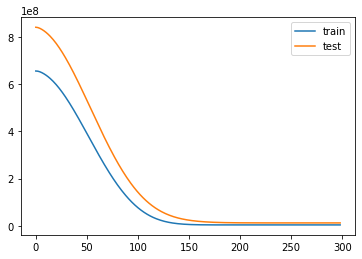

In [8]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

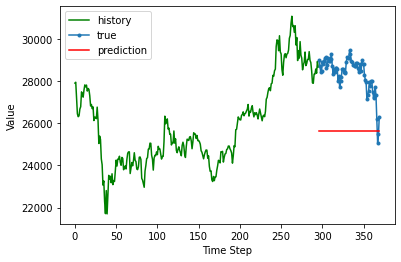

In [9]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
# plt.plot(np.arange(0, len(y_train)), sc_y.inverse_transform(y_train), 'g', label="history")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_test), marker='.', label="true")
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), sc_y.inverse_transform(y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

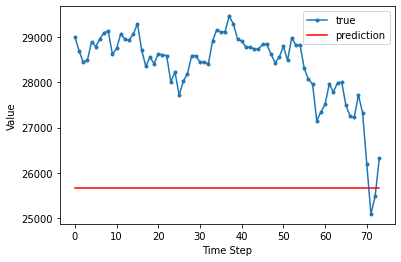

In [10]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [11]:
r2_score(y_test,y_pred)

-10.675736638485406

In [12]:
mean_absolute_percentage_error(y_test,y_pred)

0.0952868113922319

In [13]:
mean_squared_error(y_test,y_pred,squared=False)

2826.093474133847

In [15]:
x_val=data_val.drop('Prediction',1).values
y_val=data_val['Prediction']
x_val=x_val.reshape(x_val.shape[0],1,x_val.shape[1])
# x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)
# y_val_pred=sc_y.inverse_transform(y_val_pred)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_45935/343858673.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1).values


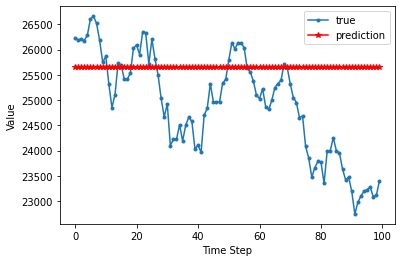

In [16]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [17]:
r2_score(y_val,y_val_pred)

-0.5424972969209456

In [18]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.04099626327965085

In [19]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

1259.344608335191